In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [2]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [3]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00


In [4]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [5]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [6]:
!mkdir -p {HOME}/data

!wget -q https://res.cloudinary.com/dw5dfwdv2/image/upload/v1741052112/r6gw0vprisriphbubw1z.jpg -P {HOME}/data
!wget -q https://res.cloudinary.com/dw5dfwdv2/image/upload/v1741052113/eowlejjqpavxqh4htxh8.jpg -P {HOME}/data
!wget -q https://res.cloudinary.com/dw5dfwdv2/image/upload/v1741052113/wdmgkydnkkh80kh8c6uh.jpg -P {HOME}/data
!wget -q https://res.cloudinary.com/dw5dfwdv2/image/upload/v1741052112/cg269uzajovcjxblsj1t.jpg -P {HOME}/data
!wget -q https://res.cloudinary.com/dw5dfwdv2/image/upload/v1741052110/bpwsgjactvhtkc2sa9yb.jpg -P {HOME}/data
!wget -q https://res.cloudinary.com/dw5dfwdv2/image/upload/v1741052110/nxtmhyjcidqvpjom6am3.jpg -P {HOME}/data


In [7]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [8]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [9]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [10]:
IMAGE_NAME = '/content/data/nxtmhyjcidqvpjom6am3.jpg'
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [11]:
import cv2

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)



In [12]:
sam_result = mask_generator.generate(image_rgb)

In [13]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


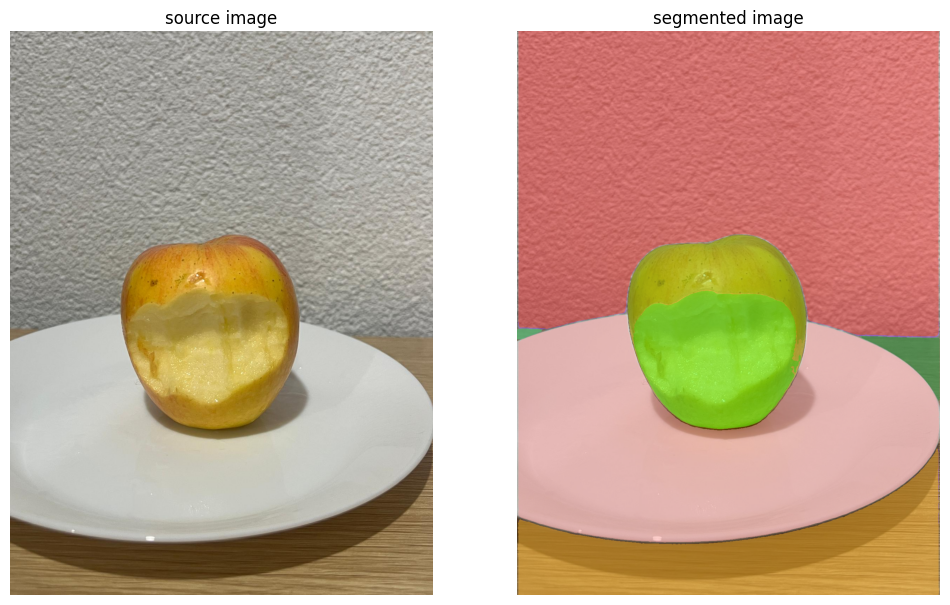

In [14]:
import supervision as sv

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

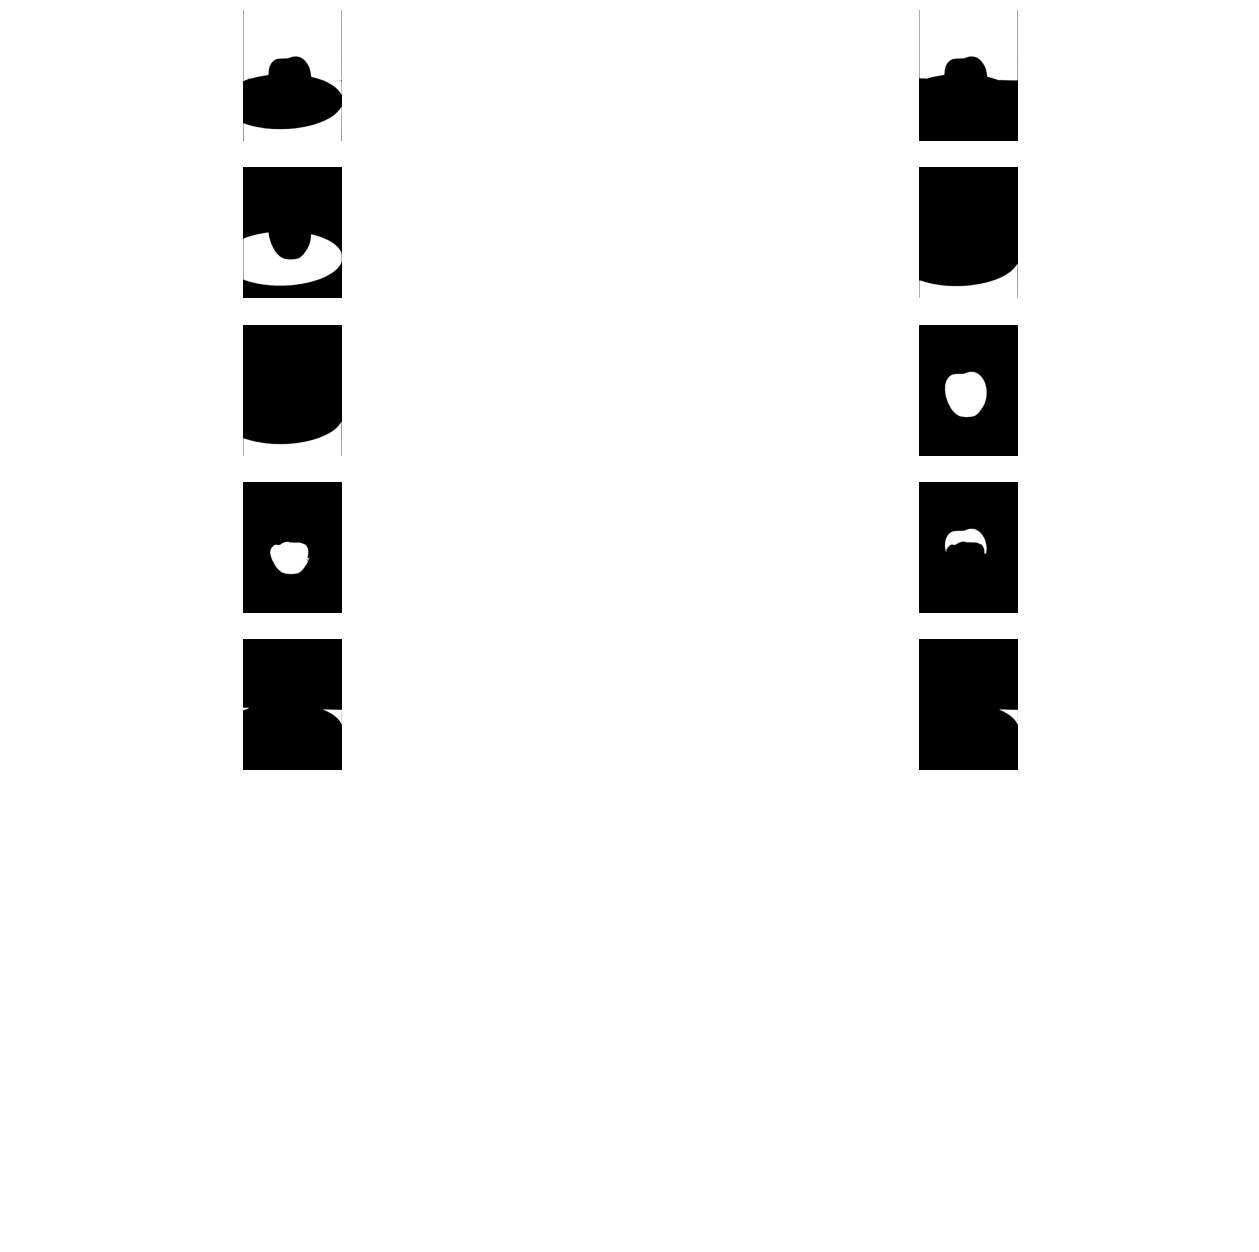

In [15]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 4)),
    size=(16, 16)
)

# **Segmentation with Bounding Box**


In [16]:
mask_predictor = SamPredictor(sam)

In [17]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [18]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

In [19]:
widget.bboxes

[{'x': 273, 'y': 502, 'width': 613, 'height': 665, 'label': ''}]

In [20]:
import numpy as np

# default_box is used when there is no manually drawen box on the image
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [21]:
def segment_food(image_path):
    """Segments food from an image using SAM and returns the largest mask (assumed to be the apple)."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image {image_path}")
        return None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.resize(image_rgb, (1024, 1024))  # Resize for consistency

    masks = mask_generator.generate(image_rgb)

    if not masks:
        print(f"No segmentation found in {image_path}")
        return None, None

    # Extract the largest mask based on pixel count
    largest_mask = max(masks, key=lambda x: np.sum(x["segmentation"]))["segmentation"]

    return image_rgb, largest_mask.astype(np.uint8)  # Convert boolean to uint8

In [22]:
def segmented_imgages_and_masks(image_path):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    mask_predictor.set_image(image_rgb)

    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )

    box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
    mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks
    )
    detections = detections[detections.area == np.max(detections.area)]

    source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    source_and_segmented_images = sv.plot_images_grid(
        images=[source_image, segmented_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )

    image_masks = sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
    )

    return masks, source_and_segmented_images, image_masks

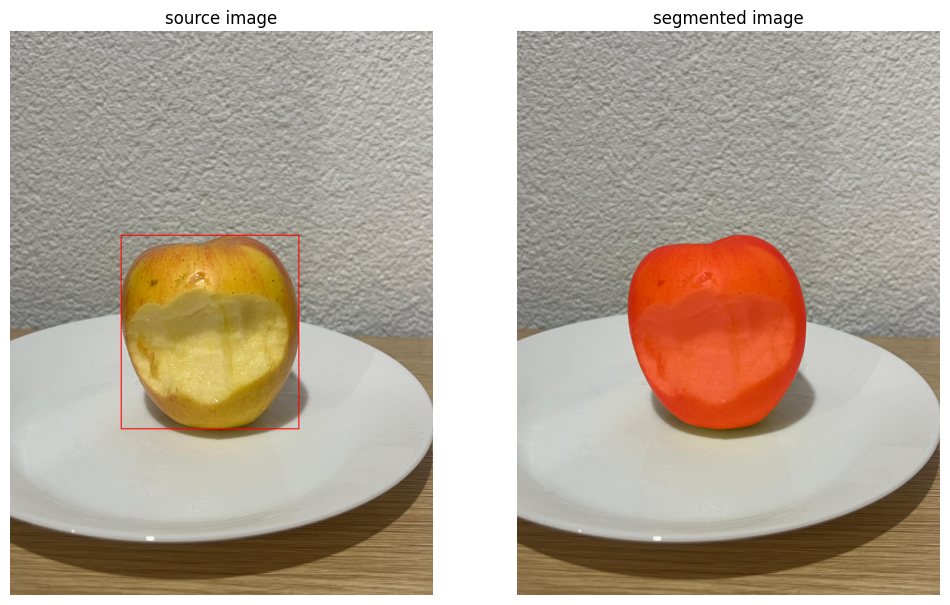

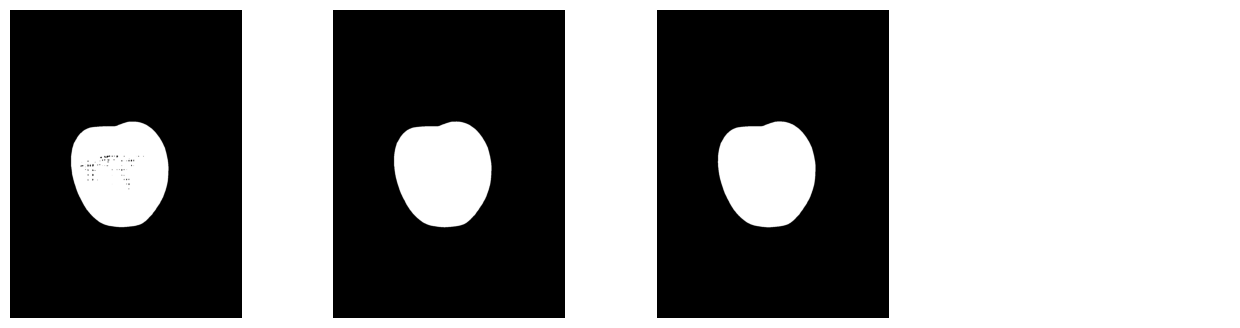

(array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fa

In [23]:
print(segmented_imgages_and_masks(IMAGE_PATH))

# **Computing Eaten Percentage**

In [24]:
Whole_Image_Name = '/content/data/bpwsgjactvhtkc2sa9yb.jpg'
Whole_Image_Path = os.path.join(HOME, "data", Whole_Image_Name)

In [25]:
def calculate_percentage_eaten_2D(whole_apple_img, partially_eaten_img):
    """Computes the percentage of the apple eaten by comparing segmented areas."""
    _, whole_mask = segment_food(whole_apple_img)
    _, partial_mask = segment_food(partially_eaten_img)

    if whole_mask is None or partial_mask is None:
        print("Segmentation failed. Ensure images are clear and well-lit.")
        return None

    # Ensure masks are boolean arrays
    whole_mask = whole_mask.astype(np.uint8)
    partial_mask = partial_mask.astype(np.uint8)

    whole_area = np.sum(whole_mask)  # Count nonzero pixels
    partial_area = np.sum(partial_mask)  # Count nonzero pixels

    if whole_area == 0:  # Prevent division by zero
        print("Error: Whole apple segmentation failed.")
        return None

    percentage_eaten = (1 - (partial_area / whole_area)) * 100
    return max(0, min(percentage_eaten, 100))  # Ensure result is between 0-100%



In [26]:
whole_apple_image = '/content/data/bpwsgjactvhtkc2sa9yb.jpg'
partially_eaten_image = '/content/data/nxtmhyjcidqvpjom6am3.jpg'

# Compute and print the percentage eaten
percentage_eaten = calculate_percentage_eaten_2D(whole_apple_image, partially_eaten_image)
if percentage_eaten is not None:
    print(f"Estimated percentage of apple eaten: {percentage_eaten:.2f}%")

Estimated percentage of apple eaten: 43.44%


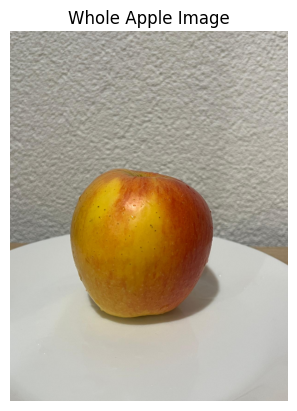

In [27]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img_whole = Image.open(whole_apple_image)
img_array = np.array(img_whole)


plt.imshow(img_array)
plt.axis('Off')
plt.title('Whole Apple Image')
plt.show()

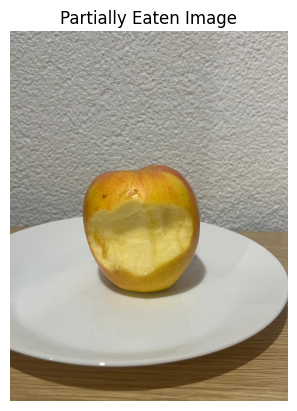

In [28]:
img_eaten = Image.open(partially_eaten_image)
img_array2 = np.array(img_eaten)


plt.imshow(img_array2)
plt.axis('Off')
plt.title('Partially Eaten Image')
plt.show()


In [29]:
from transformers import DPTForDepthEstimation, DPTFeatureExtractor

# Load MiDaS depth estimation model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
processor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

In [30]:
!pip install torch torchvision
!git clone https://github.com/isl-org/MiDaS.git

import gdown

midas_model_url = "https://github.com/isl-org/MiDaS/releases/download/v3_1/dpt_large.pt"
output_path = "MiDaS/weights/dpt_large.pt"

!mkdir -p MiDaS/weights  # Create the weights directory if it doesn't exist
gdown.download(midas_model_url, output_path, quiet=False)

import sys
sys.path.append("MiDaS")

Cloning into 'MiDaS'...
remote: Enumerating objects: 622, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 622 (delta 185), reused 138 (delta 138), pack-reused 378 (from 2)
Receiving objects: 100% (622/622), 3.44 MiB | 3.84 MiB/s, done.
Resolving deltas: 100% (249/249), done.


Downloading...
From: https://github.com/isl-org/MiDaS/releases/download/v3_1/dpt_large.pt
To: /content/MiDaS/weights/dpt_large.pt
100%|██████████| 9.00/9.00 [00:00<00:00, 45.1kB/s]


In [31]:
!wget -O sam_vit_h_4b8939.pth "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"


--2026-01-20 06:23:33--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.90, 13.35.37.111, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   200MB/s    in 24s     

2026-01-20 06:23:57 (103 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [32]:
import torch
from segment_anything import sam_model_registry, SamPredictor

# Define model and checkpoint path
model_type = "vit_h"
sam_checkpoint_path = "sam_vit_h_4b8939.pth"

# Ensure the device is set
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the SAM model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint_path)
sam.to(device)

# Initialize the predictor
predictor = SamPredictor(sam)

print("Model loaded successfully!")

Model loaded successfully!


In [33]:
import urllib.request
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Load MiDaS depth estimation model
def load_midas():
    midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")  # Use MiDaS_small for speed
    midas.to("cuda" if torch.cuda.is_available() else "cpu")
    midas.eval()
    transform = Compose([
        Resize((384, 384)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return midas, transform

# Estimate depth from an image
from PIL import Image  # Import PIL at the top

def estimate_depth(image, model, transform):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image_pil = Image.fromarray(image)  # Convert NumPy array to PIL image
    image_tensor = transform(image_pil).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        depth_map = model(image_tensor)

    depth_map = depth_map.squeeze().cpu().numpy()
    depth_map = cv2.resize(depth_map, (1024, 1024))  # Resize to match segmentation
    return depth_map

# Compute volume by summing depth inside the mask
def compute_volume(depth_map, mask):
    return np.sum(depth_map[mask > 0])  # Sum depths only where the apple exists

# Compare whole and partially eaten apple to estimate percentage eaten
def estimate_eaten_percentage_3D(whole_image_path, partial_image_path):
    whole_image, whole_mask = segment_food(whole_image_path)
    partial_image, partial_mask = segment_food(partial_image_path)

    if whole_image is None or partial_image is None:
        return None

    # Load MiDaS model
    midas, transform = load_midas()

    # Estimate depth
    whole_depth = estimate_depth(whole_image, midas, transform)
    partial_depth = estimate_depth(partial_image, midas, transform)

    # Compute volumes
    whole_volume = compute_volume(whole_depth, whole_mask)
    partial_volume = compute_volume(partial_depth, partial_mask)

    # Calculate the percentage eaten
    percentage_eaten = ((whole_volume - partial_volume) / whole_volume) * 100
    return max(0, min(100, percentage_eaten))  # Ensure percentage is between 0-100%


In [34]:
percentage_eaten = estimate_eaten_percentage_3D(whole_apple_image, partially_eaten_image)
print(f"Estimated percentage of apple eaten: {percentage_eaten:.3f}%")

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


Loading weights:  None
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt


100%|██████████| 81.8M/81.8M [00:00<00:00, 145MB/s]


Estimated percentage of apple eaten: 73.689%
